## Обробка зображень. Лабораторна робота №3

### Краснощок Іван, ІПС-31

Для кожної точки зображення з коорднатами $x, y$ (окрім крайових) визначаємо вікно 3 х 3:  
\begin{pmatrix}
f ( x - 1,y - 1)  & f ( x - 1,y)  & f ( x - 1,y+1)  \\
f ( x,y - 1)  & f (x,y )  & f (x,y+1)  \\
f ( x+1,y - 1 )  & f ( x+1, y)  & f (x+1,y+1) 
\end{pmatrix}
на основі якого будується апроксимуюча площина:
$$\hat{f} ( x,y) = ax^2 + by^2 + cxy + \alpha x+ \beta y+ \gamma$$
Після знаходження коефіцієнтів $a, b, ..., \gamma$ (за допомогою МНК) знаходимо значення частинних похідних:
$$\hat{f}_x = 2ax + cy + \alpha, \hat{f}_y=2by + cx + \beta$$
Значенням точки з координатами $x, y$ в результуючому зображенні буде ціла частина модуля градієнта: 
$$|\nabla \hat{f}(x, y)|=\sqrt{\hat{f}_x^2 + \hat{f}_y^2}$$

Код програми:

In [1]:
from typing import Tuple, Iterable, Final

import math

import numpy as np
from PIL import Image
from numba import njit

In [2]:
@njit
def get_image_contour(image_arr: np.ndarray) -> np.ndarray:    
    result = np.zeros(image_arr.shape)
    
    X = np.array([[i * i, j * j, i * j, i, j, 1] for i in range(0, 3) for j in range(0, 3)], dtype=np.float64)
    A = X.T @ X
    A_inv = np.linalg.inv(A)

    m, n = image_arr.shape
    for x in range(1, m - 1):
        for y in range(1, n - 1):
            b = X.T @ image_arr[x - 1:x + 2, y - 1:y + 2].flatten().astype(np.float64)
            
            a, b, c, alpha, beta, gamma = A_inv @ b
            
            df_dx, df_dy = 2 * a + c + alpha, 2 * b + c + beta
            
            result[x, y] = math.sqrt(df_dx * df_dx + df_dy * df_dy)
            
    min_, max_ = np.min(result), np.max(result)
    result = (result - min_) / (max_ - min_) * 255

    return result.astype(np.uint8)

Допоміжні функції:









In [3]:
VALUE_LENGTH = 8


def show_image(image: Image.Image) -> Image.Image:
    target_width = 400
    target_height = int((target_width / image.width) * image.height)
    return image.resize((target_width, target_height))


def value_to_str(value: float) -> str:
    value_str = str(value)
    
    if len(value_str) > VALUE_LENGTH:
        value_str = f'{value:.1e}'
        
    return value_str.rjust(VALUE_LENGTH)


def row_to_str(row: Iterable) -> str:
    return f'({" ".join(value_to_str(value) for value in row)})'
    

def print_equation_system(A: np.ndarray, x: np.ndarray, b: np.ndarray) -> None:
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    
    A_row_len = (len(A[0]) + 1) * VALUE_LENGTH
    x_row_len = b_row_len = int(1.5 * VALUE_LENGTH)
    
    print('A'.rjust(A_row_len), 'x'.rjust(x_row_len), 'b'.rjust(b_row_len))
    
    for A_row, x_row, b_row in zip(A, x, b):
        print(row_to_str(A_row).rjust(A_row_len), row_to_str(x_row).rjust(x_row_len), row_to_str(b_row).rjust(b_row_len))

Початкове зображення 'cameraman.tif':

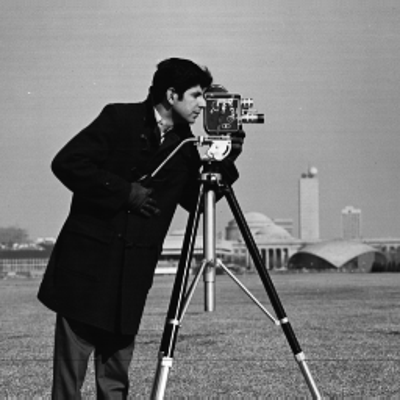

In [4]:
image = Image.open('cameraman.tif')
show_image(image)

Результат роботи програми:

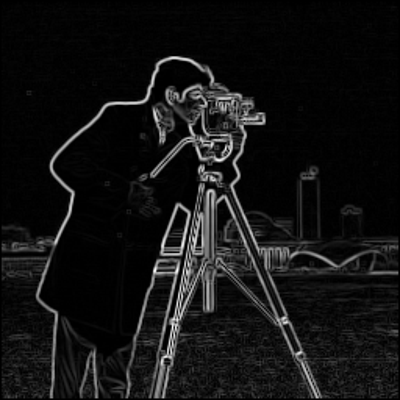

In [5]:
image_arr = np.array(image)
show_image(Image.fromarray(get_image_contour(image_arr)))

Система рівнянь для точки з координатами $(1, 1)$ (індексація починається з 0):

In [6]:
X = np.array([[i * i, j * j, i * j, i, j, 1] for i in range(0, 3) for j in range(0, 3)], dtype=np.float64)

A = X.T @ X
b = X.T @ image_arr[0:3, 0:3].flatten().astype(np.float64)
x = np.linalg.inv(A) @ b

print_equation_system(A, x, b)

                                                       A            x            b
 (    51.0     25.0     27.0     27.0     15.0     15.0)   ( 6.7e-01)   (  2363.0)
 (    25.0     51.0     27.0     15.0     27.0     15.0)   ( 1.7e-01)   (  2364.0)
 (    27.0     27.0     25.0     15.0     15.0      9.0)   ( 2.3e-13)   (  1418.0)
 (    27.0     15.0     15.0     15.0      9.0      9.0)   (-1.3e+00)   (  1417.0)
 (    15.0     27.0     15.0      9.0     15.0      9.0)   (-1.7e-01)   (  1418.0)
 (    15.0     15.0      9.0      9.0      9.0      9.0)   ( 1.6e+02)   (  1417.0)


Час роботи програми в середньому (використано пакет numba, що прискорює python код шляхом JIT компіляції):

In [7]:
%%timeit -n5 -r5
get_image_contour(image_arr)

41.6 ms ± 6.66 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
